In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from zmq.green import device



C:\Users\AriaMei\AppData\Local\Temp\ipykernel_36968\673250627.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\AriaMei\AppData\Local\Temp\ipykernel_36968\673250627.py:7: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# df = pd.read_csv('Macau_weather_dataset.csv',parse_dates=['Date'],index_col='Date')
df = pd.read_csv('Macau_weather_dataset.csv')
print(df.shape)

print(df.head(5))

(7537, 7)
       Date  Mean maximum (oC)  Mean(oC)  Mean minimum(oC)  \
0  1999/1/1               21.8      18.5              16.2   
1  1999/1/2               18.3      16.0              12.9   
2  1999/1/3               18.7      15.7              12.1   
3  1999/1/4               20.3      16.8              13.1   
4  1999/1/5               21.4      16.5              13.5   

   Mean relative humidity (%)  Insolation duration\n(hour) Total rainfall (mm)  
0                          74                          7.0                   0  
1                          69                          7.8                   0  
2                          67                          9.0                   0  
3                          59                          9.3                   0  
4                          65                          9.4                   0  


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
columns = df.columns.tolist()
columns[1] = 'MaxTem'
columns[2] = 'MeanTem'
columns[3] = 'MinTem'
columns[4] = 'MeanRelHum'
columns[5] = 'IsoD'
columns[6] = 'TotRain'
df.columns = columns
# Date = df.columns[0]
# Max = df.columns[1]
# Mean = df.columns[2]
# Min = df.columns[3]
# MRH = df.columns[4]
# IsoD = df.columns[5]
# TotRain = df.columns[6] 


In [5]:
print(df.columns)

Index(['Date', 'MaxTem', 'MeanTem', 'MinTem', 'MeanRelHum', 'IsoD', 'TotRain'], dtype='object')


Change VCT to 0.1 to calculate

In [6]:
df['TotRain'] = df['TotRain'].replace('VST', 0.1).astype(float)


In [7]:
TestSet = df.iloc[np.arange(0, len(df), 30)]
TrainSet = df.drop(TestSet.index)
print(TestSet.shape)
print(TrainSet.shape)

(252, 7)
(7285, 7)


In [9]:
print(df['Date'].head(5))

0   1999-01-01
1   1999-01-02
2   1999-01-03
3   1999-01-04
4   1999-01-05
Name: Date, dtype: datetime64[ns]


select the feature

In [10]:
features = df.columns[1:]  # 排除日期列

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[features])

In [11]:
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(X[(i + time_steps), :])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train, y_train = create_dataset(df_scaled, time_steps)

In [12]:
X_train.shape, y_train.shape

((7507, 30, 6), (7507, 6))

In [13]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(CustomLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

In [33]:
from sklearn.metrics import mean_squared_error
import os

model = CustomLSTM(input_size=6, hidden_layer_size=50, output_size=6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
model_path = './log/lstm_model.pth'
optimizer_path = './log/optimizer.pth'

if os.path.exists(model_path) and os.path.exists(optimizer_path):
    
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))
    print("Loaded saved model and optimizer state.")
    model.eval()  
else:
    print("No saved model found. Starting training from scratch.")
   
    num_epochs = 50
    criterion = nn.MSELoss()




n_records = len(df_scaled)
train_size = n_records - 30  # last 30 data for prediction


predictions = []
actuals = []


for epoch in range(num_epochs):  
    for t in range(train_size):
        # prepare datset
        train_X = torch.tensor(df_scaled[t:t+30], dtype=torch.float32).unsqueeze(0)  
        train_y = torch.tensor(df_scaled[t+1:t+31], dtype=torch.float32).unsqueeze(0)[:, -1, :]  # feature of next time stamp

        # training model
        model.train()
        optimizer.zero_grad()
        output = model(train_X)
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()

    #print loss
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

 
    model.eval()
    with torch.no_grad():
        future_X = torch.tensor(df_scaled[train_size:train_size+30], dtype=torch.float32).unsqueeze(0)
        future_pred = model(future_X)
        predictions.append(future_pred.numpy().flatten())
        actuals.append(df_scaled[train_size])

# compute loss of prediction
predictions = np.array(predictions)
actuals = np.array(actuals)
mse = mean_squared_error(actuals, predictions)

No saved model found. Starting training from scratch.
Epoch 1/50, Loss: 0.003167530754581094
Epoch 2/50, Loss: 0.00250898371450603
Epoch 3/50, Loss: 0.002208417747169733
Epoch 4/50, Loss: 0.0019787142518907785
Epoch 5/50, Loss: 0.0017822074005380273
Epoch 6/50, Loss: 0.001835052971728146
Epoch 7/50, Loss: 0.0016971762524917722
Epoch 8/50, Loss: 0.0017156043322756886
Epoch 9/50, Loss: 0.0017144003650173545
Epoch 10/50, Loss: 0.001661228365264833
Epoch 11/50, Loss: 0.0015220908680930734
Epoch 12/50, Loss: 0.0014044027775526047
Epoch 13/50, Loss: 0.0013550355797633529
Epoch 14/50, Loss: 0.0013324023457244039
Epoch 15/50, Loss: 0.0012996558798477054
Epoch 16/50, Loss: 0.0012516494607552886
Epoch 17/50, Loss: 0.0012220378266647458
Epoch 18/50, Loss: 0.0012304923729971051
Epoch 19/50, Loss: 0.001255795476026833
Epoch 20/50, Loss: 0.001284017344005406
Epoch 21/50, Loss: 0.0013469536788761616
Epoch 22/50, Loss: 0.0014418215723708272
Epoch 23/50, Loss: 0.0015314220217987895
Epoch 24/50, Loss: 0

In [35]:
torch.save(model.state_dict(), './log/lstm_model.pth')
torch.save(optimizer.state_dict(), './log/optimizer.pth')

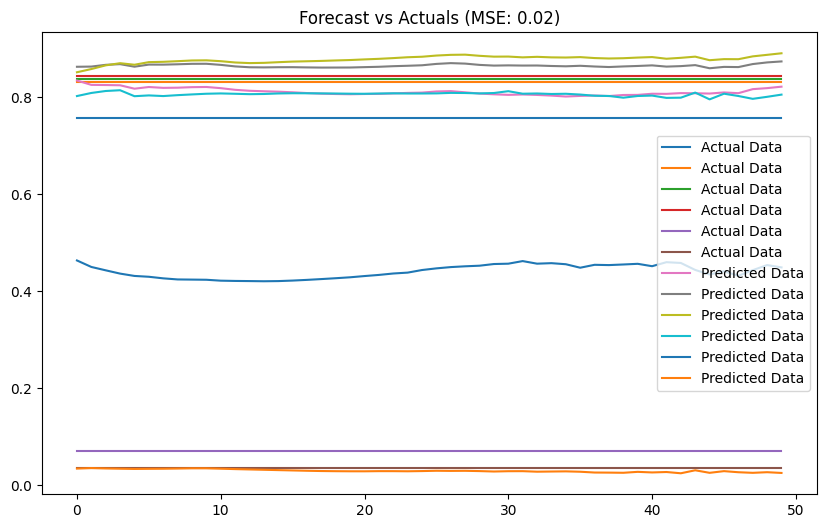

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Data')
plt.plot(predictions, label='Predicted Data')
plt.title(f'Forecast vs Actuals (MSE: {mse:.2f})')
plt.legend()
plt.show()

In [37]:
model.eval()


test_input = df_scaled[-30:]  # 
test_input = torch.tensor(test_input, dtype=torch.float32).unsqueeze(0)  # shape is  (1, 30, 6)


predictions = []

# rolling predict for 30 days
with torch.no_grad():
    for _ in range(30):
        # 预测当前时间步
        prediction = model(test_input)
        
        
        predictions.append(prediction.squeeze().numpy())
        
        
        next_input = prediction.unsqueeze(0)
        test_input = torch.cat((test_input[:, 1:, :], next_input), dim=1)  

predictions = np.array(predictions)


predictions_rescaled = scaler.inverse_transform(predictions)




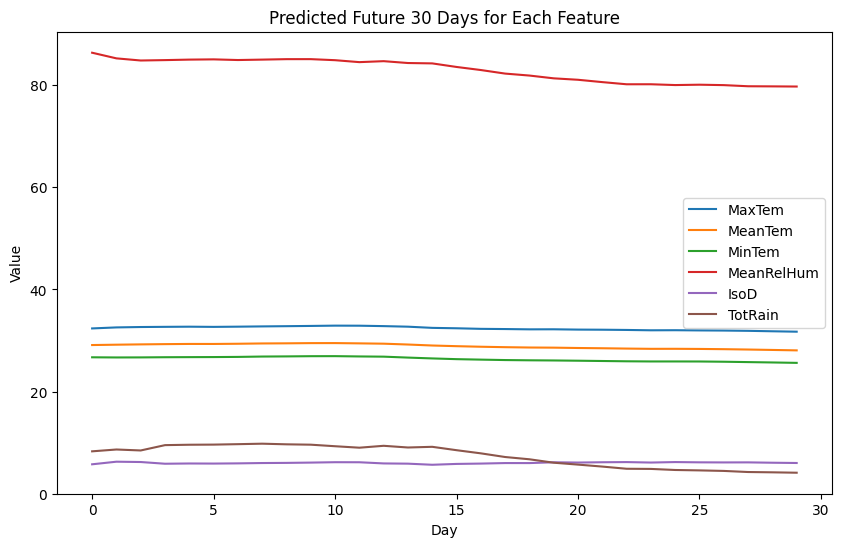

In [38]:
plt.figure(figsize=(10, 6))
feature_names=['MaxTem', 'MeanTem', 'MinTem', 'MeanRelHum', 'IsoD', 'TotRain']
# 绘制每个特征的预测结果
for i, feature_name in enumerate(feature_names):
    plt.plot(predictions_rescaled[:, i], label=feature_name)

plt.title('Predicted Future 30 Days for Each Feature')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()

In [39]:
print(predictions_rescaled.shape)
print(predictions_rescaled)

(30, 6)
[[32.36081   29.107018  26.70735   86.360954   5.7498436  8.289654 ]
 [32.560654  29.176037  26.676277  85.25519    6.259141   8.648929 ]
 [32.63699   29.236591  26.68668   84.837326   6.1957655  8.45953  ]
 [32.67219   29.287025  26.72134   84.914764   5.859714   9.503887 ]
 [32.70191   29.323605  26.73905   85.011215   5.9093246  9.580781 ]
 [32.664436  29.320366  26.752436  85.05941    5.893023   9.606389 ]
 [32.705704  29.360453  26.783813  84.92958    5.931772   9.692518 ]
 [32.757835  29.419298  26.854221  85.011635   5.997264   9.787157 ]
 [32.801296  29.443758  26.882452  85.10125    6.0263343  9.66254  ]
 [32.850235  29.483541  26.923792  85.10345    6.08393    9.5912695]
 [32.90795   29.490011  26.932707  84.89774    6.159218   9.288245 ]
 [32.89516   29.435104  26.873287  84.51697    6.1503825  9.001454 ]
 [32.813183  29.372997  26.83249   84.70718    5.9200125  9.3733425]
 [32.703857  29.209002  26.650269  84.34284    5.874971   9.041237 ]
 [32.470966  29.01629   26

Select Temperature and grouped by month

In [14]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['YearMonth'] = df['Date'].dt.strftime('%Y-%m')

In [15]:

app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Macau Weather Dashboard"),
    dcc.Graph(id='temp-graph'),
    dcc.Slider(
        id='year-slider',
        min=df['Year'].min(),
        max=df['Year'].max(),
        value=df['Year'].min(),
        marks={str(year): str(year) for year in df['Year'].unique()},
        step=None
    )
])


In [16]:
@app.callback(
    Output('temp-graph', 'figure'),
    [Input('year-slider', 'value')])
def update_figure(selected_year):
    filtered_df = df[df['Year'] == selected_year]
    fig = px.line(filtered_df, x='Month', y='MeanTem', title='Average Temperature Over Time')
    fig.update_layout(transition_duration=500)
    return fig


In [17]:
app.run_server(debug=True)

Using heatmap to show isolation duration time per day

In [13]:
monthly_data = df.groupby('YearMonth').agg({'IsoD': 'mean'}).reset_index()

#draw heat map
fig = px.imshow([monthly_data['IsoD']], text_auto=True,
                labels=dict(x="Year-Month", y="Average Insolation Duration", color="Hours"),
                x=monthly_data['YearMonth'],
                title="Average Insolation Duration by Year-Month Combination")
fig.update_xaxes(side="bottom")
fig.show()

Correlation Matrix of Weather Variables

In [23]:
corr_matrix = df[['MaxTem', 'MeanTem', 'MinTem', 'MeanRelHum', 'IsoD', 'TotRain']].corr()

# 使用 Plotly 绘制热图
fig = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                labels=dict(x="Feature", y="Feature", color="Correlation"),
                title="Correlation Matrix of Weather Variables")
fig.update_xaxes(side="bottom")
fig.show()

box plot for temperature

In [20]:
fig = px.box(df, x='YearMonth', y='MeanTem', 
             title='Monthly Average Temperature Over Years',
             labels={'YearMonth': 'Year-Month', 'MeanTem': 'Average Temperature (°C)'},
             category_orders={"YearMonth": sorted(df['YearMonth'].unique())})  # 确保 x 轴按时间顺序排序

fig.show()


In [12]:
MaxTem_M= df.iloc[:, 1].groupby(df['Date'].dt.month).mean()
MeanTem_M= df.iloc[:, 2].groupby(df['Date'].dt.month).mean()
MinTem_M= df.iloc[:, 3].groupby(df['Date'].dt.month).mean()

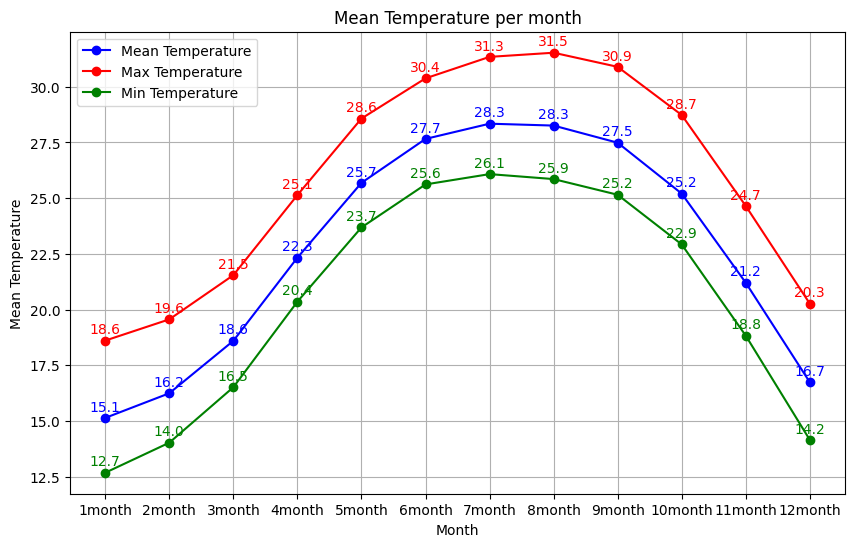

In [18]:
plt.figure(figsize=(10, 6))
#MaxTemperature
plt.plot(MeanTem_M.index, MeanTem_M.values, marker='o', linestyle='-', color='b', label='Mean Temperature')

# MeanTemperature
plt.plot(MaxTem_M.index, MaxTem_M.values, marker='o', linestyle='-', color='r', label='Max Temperature')

# MinTemperature
plt.plot(MinTem_M.index, MinTem_M.values, marker='o', linestyle='-', color='g', label='Min Temperature')

for i in range(len(MeanTem_M)):
    plt.annotate(f'{MeanTem_M.values[i]:.1f}', xy=(MeanTem_M.index[i], MeanTem_M.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='blue')

for i in range(len(MaxTem_M)):
    plt.annotate(f'{MaxTem_M.values[i]:.1f}', xy=(MaxTem_M.index[i], MaxTem_M.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='red')

for i in range(len(MinTem_M)):
    plt.annotate(f'{MinTem_M.values[i]:.1f}', xy=(MinTem_M.index[i], MinTem_M.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='green')
plt.xticks(ticks=MaxTem_M.index, labels=[f'{int(month)}month' for month in MaxTem_M.index])
# add tittle and label
plt.title('Mean Temperature per month')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.legend()
# show the net
plt.grid(True)


plt.show()

In [ ]:
# WholeData = {}
# year = 1998
# index = 0
# while year != 2019:
#     year += 1
#     if(year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         WholeData[f'year{year}'] = df.iloc[index:(index+366)]
#     else:
#         WholeData[f'year{year}'] = df.iloc[index:(index+365)]


In [24]:
dftemp = df.sort_values(by='Date')

# group data in different format
MeanTem_YM = dftemp.iloc[:, 1].groupby(dftemp['Date']).mean()
MaxTem_YM = dftemp.iloc[:, 2].groupby(dftemp['Date']).mean()
MinTem_YM = dftemp.iloc[:, 3].groupby(dftemp['Date']).mean()


# MeanTem_YM.index = MeanTem_YM.index.to_timestamp()
# MaxTem_YM.index = MaxTem_YM.index.to_timestamp()
# MinTem_YM.index = MinTem_YM.index.to_timestamp()


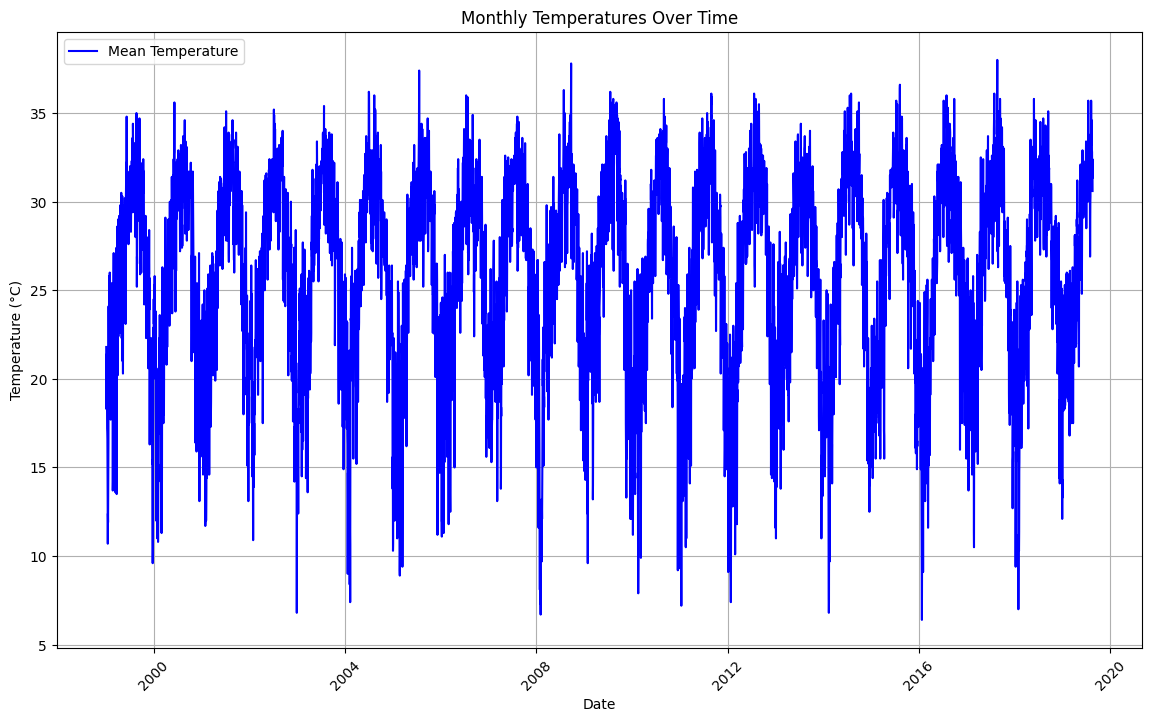

In [25]:
plt.figure(figsize=(14, 8))


plt.plot(MeanTem_YM.index, MeanTem_YM.values, linestyle='-', color='b', label='Mean Temperature')

# plt.plot(MaxTem_YM.index, MaxTem_YM.values, linestyle='-', color='r', label='Max Temperature')

# plt.plot(MinTem_YM.index, MinTem_YM.values, linestyle='-', color='g', label='Min Temperature')

# x is date
plt.xticks(rotation=45)
plt.xlabel('Date')

# y is temperature
plt.title('Monthly Temperatures Over Time')
plt.ylabel('Temperature (°C)')

plt.legend()

plt.grid(True)

plt.show()

In [17]:
df['Year'] = df['Date'].dt.year


MaxTem_Y = df.iloc[:, 2].groupby(df['Year']).max()
MinTem_Y = df.iloc[:, 3].groupby(df['Year']).min()

## Perform linear regression on MaxTem_Y
slope_max, intercept_max, r_value_max, p_value_max, std_err_max = linregress(MaxTem_Y.index, MaxTem_Y.values)
regression_line_max = slope_max * MaxTem_Y.index + intercept_max

## Perform linear regression on MinTem_Y
slope_min, intercept_min, r_value_min, p_value_min, std_err_min = linregress(MinTem_Y.index, MinTem_Y.values)
regression_line_min = slope_min * MinTem_Y.index + intercept_min


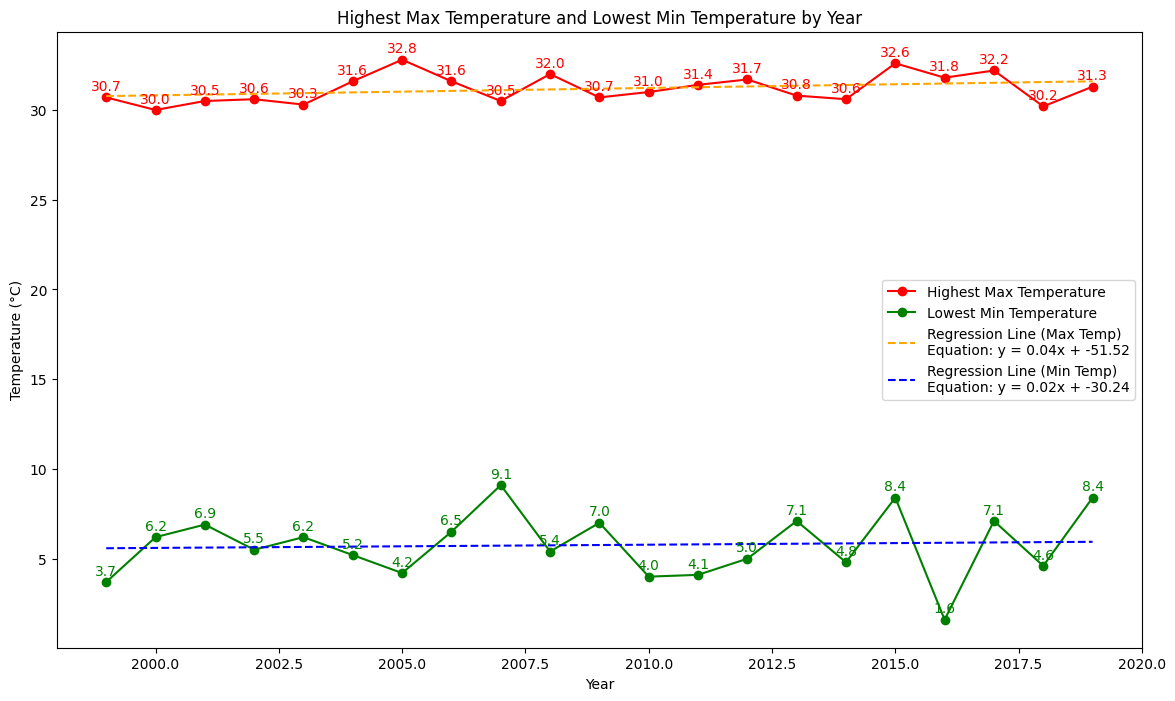

In [18]:
plt.figure(figsize=(14, 8))

# Plot the highest MaxTem for each year
plt.plot(MaxTem_Y.index, MaxTem_Y.values, marker='o', linestyle='-', color='r', label='Highest Max Temperature')

# Plot the lowest MinTem for each year
plt.plot(MinTem_Y.index, MinTem_Y.values, marker='o', linestyle='-', color='g', label='Lowest Min Temperature')
for i in range(len(MaxTem_Y)):
    plt.annotate(f'{MaxTem_Y.values[i]:.1f}', xy=(MaxTem_Y.index[i], MaxTem_Y.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='red')

for i in range(len(MinTem_Y)):
    plt.annotate(f'{MinTem_Y.values[i]:.1f}', xy=(MinTem_Y.index[i], MinTem_Y.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='green')
    
# Plot the regression line for MaxTem
plt.plot(MaxTem_Y.index, regression_line_max, color='orange', linestyle='--', 
         label=f'Regression Line (Max Temp)\nEquation: y = {slope_max:.2f}x + {intercept_max:.2f}')

# Plot the regression line for MinTem
plt.plot(MinTem_Y.index, regression_line_min, color='blue', linestyle='--', 
         label=f'Regression Line (Min Temp)\nEquation: y = {slope_min:.2f}x + {intercept_min:.2f}')


# set Year as X
plt.xlabel('Year')
plt.legend()

plt.title('Highest Max Temperature and Lowest Min Temperature by Year')
plt.ylabel('Temperature (°C)')

# show the line
plt.legend()

In [31]:
print(columns[6])
MaxTotRain = df.iloc[:, 6].groupby(df['Year']).max()
medianTotRain = df.iloc[:, 6].groupby(df['Year']).median()
MeanTotRain = df.iloc[:, 6].groupby(df['Year']).mean()

TotRain


In [32]:
print(MaxTotRain.head(5))
print(MeanTotRain.head(5))

Year
1999    169.4
2000    233.2
2001    226.0
2002    152.4
2003    142.0
Name: TotRain, dtype: float64
Year
1999    5.290137
2000    6.293169
2001    7.014795
2002    6.000274
2003    4.093151
Name: TotRain, dtype: float64


In [33]:


slope_max, intercept_max, r_value_max, p_value_max, std_err_max = linregress(MaxTotRain.index, MaxTotRain.values)
regression_line_max = slope_max * MaxTotRain.index + intercept_max

## Perform linear regression on MinTem_Y
slope_median, intercept_median, r_value_median, p_value_median, std_err_median = linregress(medianTotRain.index, medianTotRain.values)
regression_line_median = slope_median * medianTotRain.index + intercept_median

slope_mean, intercept_mean, r_value_mean, p_value_mean, std_err_mean = linregress(MeanTotRain.index, MeanTotRain.values)
regression_line_mean = slope_mean * MeanTotRain.index + intercept_mean

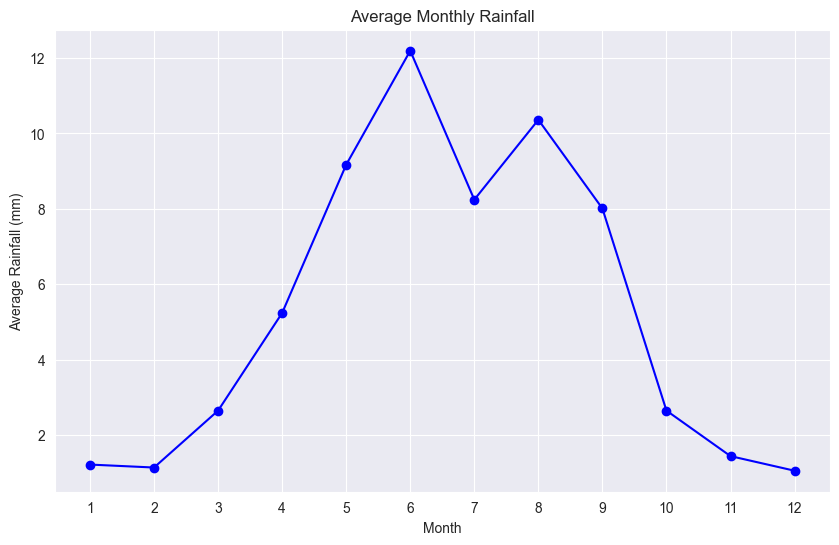

In [10]:
df['Month'] = df['Date'].dt.month
monthly_avg_rain = df.groupby('Month')['TotRain'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_rain.index, monthly_avg_rain.values, marker='o', linestyle='-', color='b')
plt.title('Average Monthly Rainfall')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.xticks(range(1, 13))  # set x from 1 to 12
plt.grid(True)
plt.show()

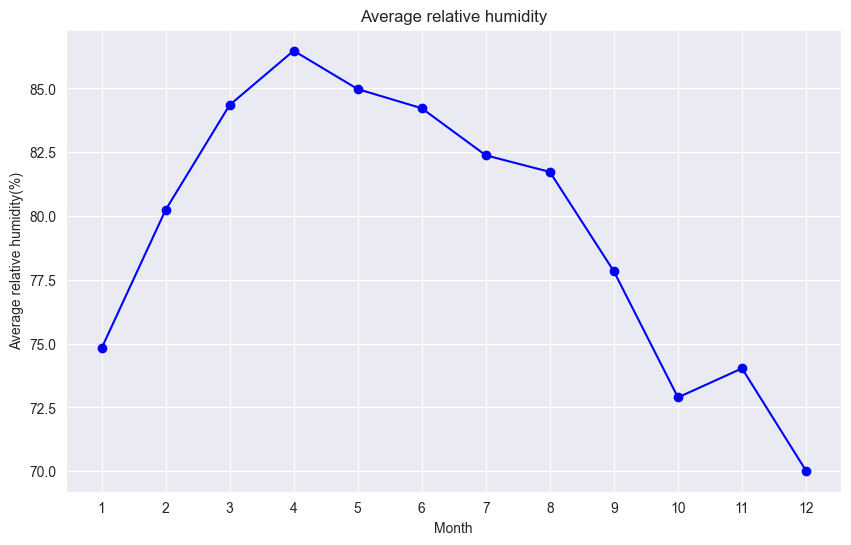

In [13]:
df['Month'] = df['Date'].dt.month
monthly_avg_rain = df.groupby('Month')['MeanRelHum'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_rain.index, monthly_avg_rain.values, marker='o', linestyle='-', color='r')
plt.title('Average relative humidity')
plt.xlabel('Month')
plt.ylabel('Average relative humidity(%)')
plt.xticks(range(1, 13))  # set x from 1 to 12
plt.grid(True)
plt.show()

C:\Users\AriaMei\AppData\Local\Temp\ipykernel_36968\3248710880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg_rain.index, y=monthly_avg_rain.values, palette='Blues_d')


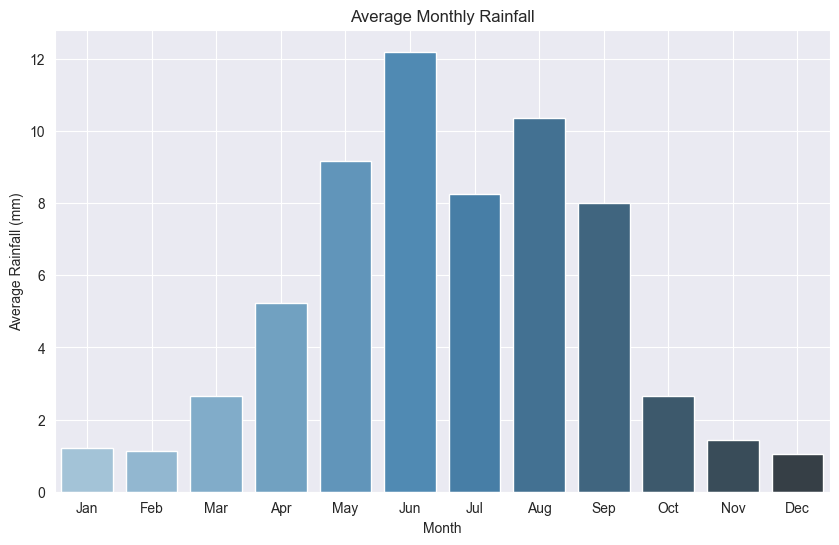

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg_rain.index, y=monthly_avg_rain.values, palette='Blues_d')
plt.title('Average Monthly Rainfall')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

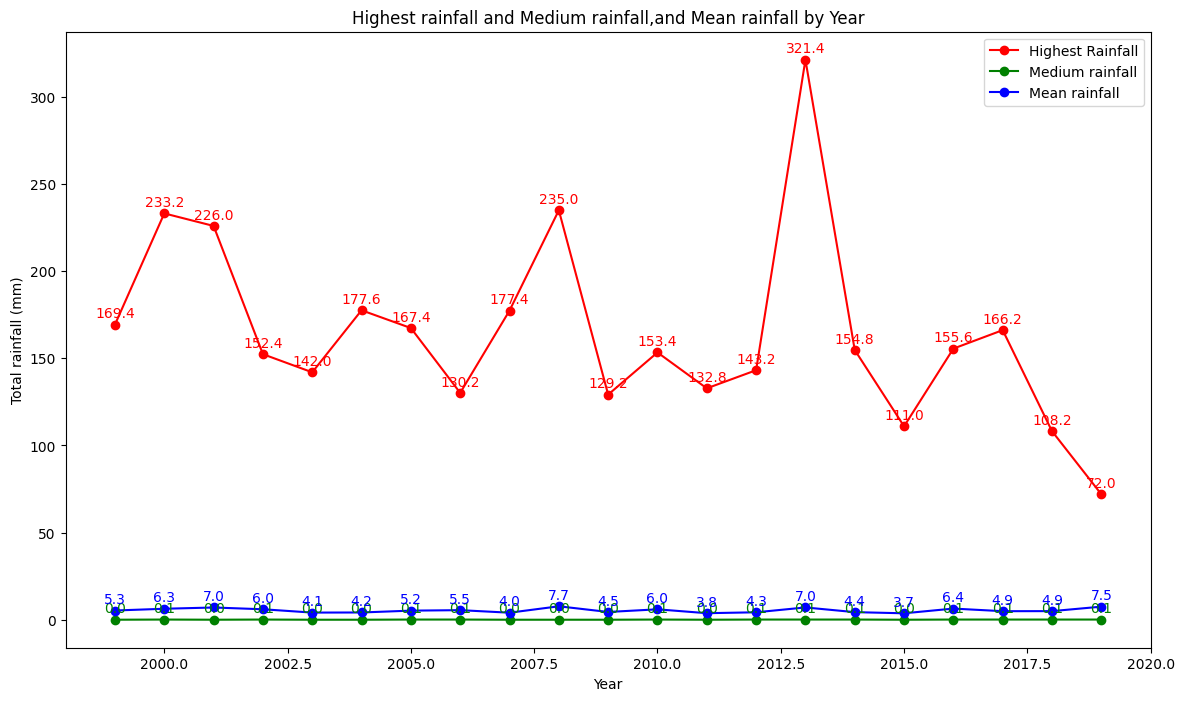

In [37]:
plt.figure(figsize=(14, 8))

# Plot the highest MaxTem for each year
plt.plot(MaxTotRain.index, MaxTotRain.values, marker='o', linestyle='-', color='r', label='Highest Rainfall')

# Plot the lowest MinTem for each year
plt.plot(medianTotRain.index, medianTotRain.values, marker='o', linestyle='-', color='g', label='Medium rainfall')

plt.plot(MeanTotRain.index, MeanTotRain.values, marker='o', linestyle='-', color='b', label='Mean rainfall')
for i in range(len(MaxTotRain)):
    plt.annotate(f'{MaxTotRain.values[i]:.1f}', xy=(MaxTotRain.index[i], MaxTotRain.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='red')

for i in range(len(medianTotRain)):
    plt.annotate(f'{medianTotRain.values[i]:.1f}', xy=(medianTotRain.index[i], medianTotRain.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='green')
for i in range(len(MeanTotRain)):
    plt.annotate(f'{MeanTotRain.values[i]:.1f}', xy=(MeanTotRain.index[i], MeanTotRain.values[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='blue')
# Plot the regression line for MaxTem

# Plot the regression line for MinTem
# plt.plot(medianTotRain.index, regression_line_min, color='white', linestyle='--', 
#          label=f'Regression Line (Min Temp)\nEquation: y = {slope_min:.2f}x + {intercept_min:.2f}')
# 
# plt.plot(MaxTotRain, regression_line_min, color='orange', linestyle='--', 
#          label=f'Regression Line (Min Temp)\nEquation: y = {slope_min:.2f}x + {intercept_min:.2f}')
# plt.plot(MeanTotRain, regression_line_mean, color='grey', linestyle='--', 
#          label=f'Regression Line (Min Temp)\nEquation: y = {slope_mean:.2f}x + {intercept_min:.2f}')
# set Year as X
plt.xlabel('Year')
plt.legend()

plt.title('Highest rainfall and Medium rainfall,and Mean rainfall by Year')
plt.ylabel('Total rainfall (mm)')

# show the line
plt.legend()

Text(0.5, 0, 'Year')

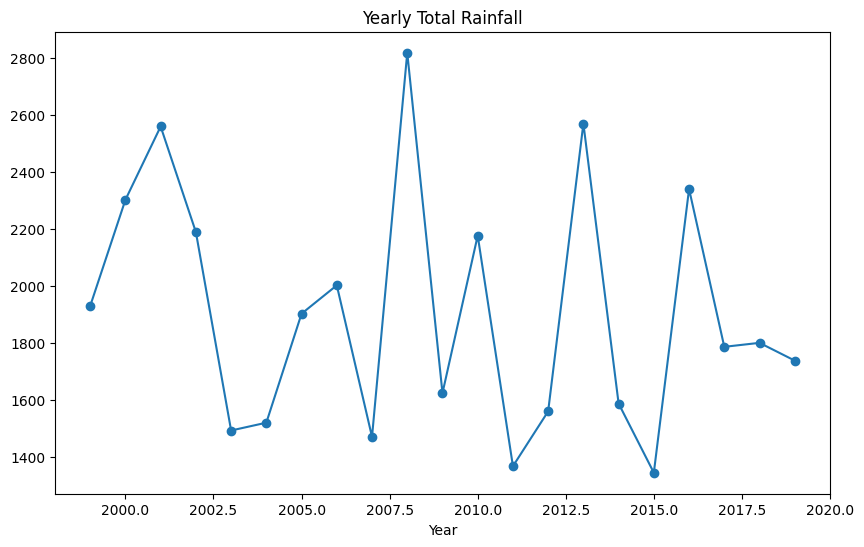

In [38]:
yearly_rain = df['TotRain'].groupby(df['Year']).sum()

df['Month'] = df['Date'].dt.month
monthly_rain = df['TotRain'].groupby(df['Month']).mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_rain.index, yearly_rain.values, marker='o')
plt.title('Yearly Total Rainfall')
plt.xlabel('Year')

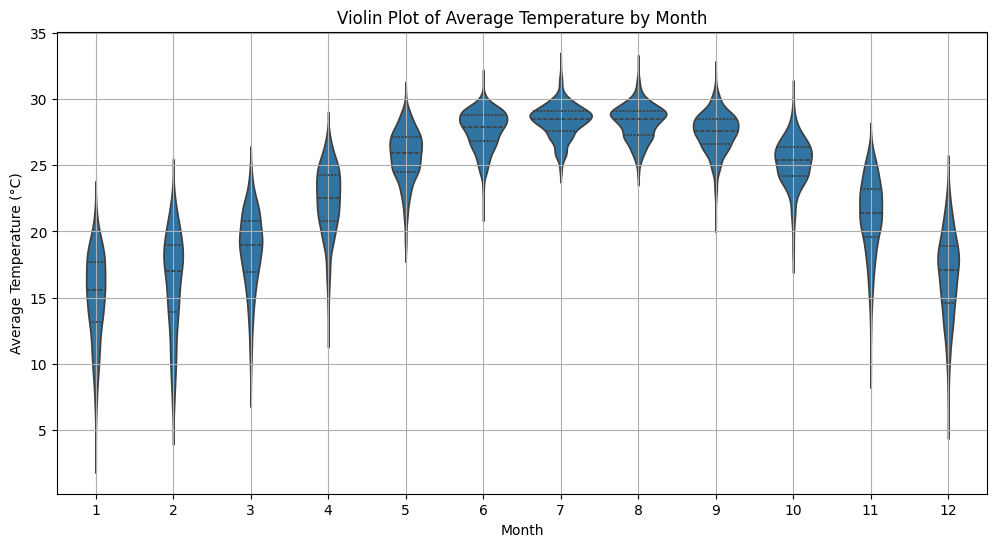

In [10]:
df['Month'] = df['Date'].dt.month

# violin
plt.figure(figsize=(12, 6))
sns.violinplot(x='Month', y='MeanTem', data=df, inner='quartile')
plt.title('Violin Plot of Average Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

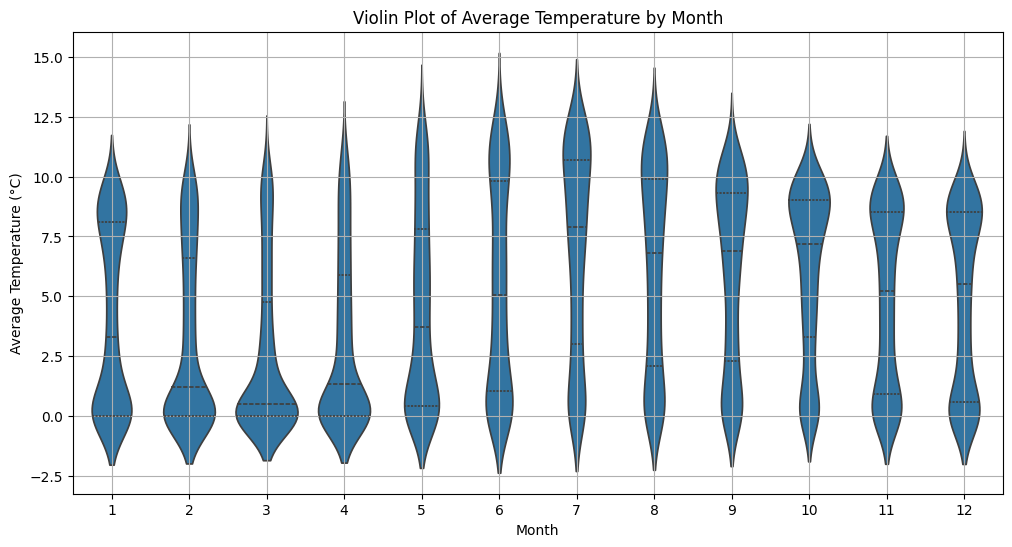

In [11]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Month', y='IsoD', data=df, inner='quartile')
plt.title('Violin Plot of Average Isolation duration by Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

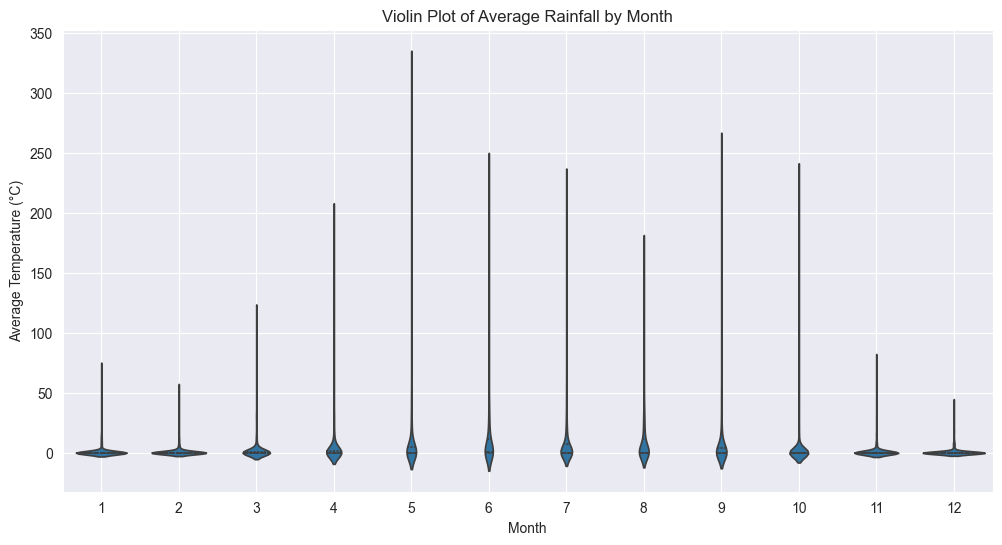

In [12]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Month', y='TotRain', data=df, inner='quartile')
plt.title('Violin Plot of Average Rainfall by Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

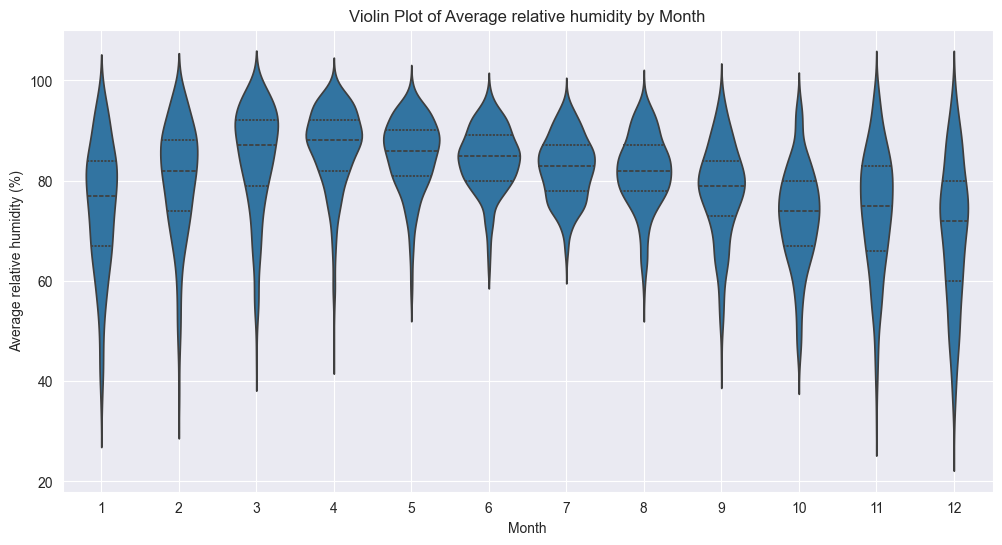

In [18]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Month', y='MeanRelHum', data=df, inner='quartile')
plt.title('Violin Plot of Average relative humidity by Month')
plt.xlabel('Month')
plt.ylabel('Average relative humidity (%)')
plt.grid(True)
plt.show()

In [22]:
count_zero_totrain = (df['TotRain'] == 0).sum()
count_Notzero_totrain = (df['TotRain'] != 0).sum()

print(f"line 'TotRain' = 0 nums: {count_zero_totrain}")
print(count_Notzero_totrain)

line 'TotRain' = 0 nums: 3758
3779
